# Cosine Similarity Example
This notebook shows an example of how to calculate and plot cosine similarity from an ImmuneDB database for versions **before v0.23.0**.

It should run as-is with no modification.  However, code segments labelled with **<font color='green'>(MODIFY)</font>** are sections that should be modified to change what is plotted (e.g. plot by tissue, filter clones by size, etc).


## Import Necessary Libraries
This sets the notebook to display plots inline and imports the libraries needed for cosine similarity and plotting.

In [1]:
%matplotlib inline

import itertools
import os

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import cosine
import seaborn as sns

from sqlalchemy.orm import joinedload

matplotlib.style.use('ggplot')

# Gather overlap data from ImmuneDB
Makes a new (or reads an existing) overlap TSV file from ImmuneDB.  The configuration below should be changed as necessary to point at the desired database.

In [2]:
df = pd.read_csv("miron.tsv", sep='\t', index_col='sample')

## Add metadata to DataFrame <font color='green'>(MODIFY)</font>
Adds columns for metadata, extracted from sample names, to easily filter and sort the DataFrame later on.  In newer versions of ImmuneDB these fields can be added in the original metdata file, but for this version we have to pull it out manually

In [3]:
num_added_fields = len(df.columns)
fields = ['subject', 'tissue', 'marker', 'subset', 'rep']


In [4]:
for i, f in enumerate(fields):
    df.insert(0, f, df.index.str.split('-').map(lambda l: l[i]))
    
df.insert(0, 'replicates', df.index.str.split('-rep').map(lambda l: l[0]))
num_added_fields = len(df.columns) - num_added_fields

In [5]:
df.head(6)

,replicates,rep,subset,marker,tissue,subject,2,4,6,7,...,62224,62226,62242,62253,62264,62272,62344,62493,62518,62539
sample,,,,,,,,,,,,,,,,,,,,,
D233-BM-CD8-TEM-rep3-200ng_S27,D233-BM-CD8-TEM,rep3,TEM,CD8,BM,D233,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D233-BM-CD8-TEM-rep4-200ng_S38,D233-BM-CD8-TEM,rep4,TEM,CD8,BM,D233,6.0,38.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D233-BM-CD8-TRM-rep3-200ng_S26,D233-BM-CD8-TRM,rep3,TRM,CD8,BM,D233,1.0,0.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D233-BM-CD8-TRM-rep4-200ng_S37,D233-BM-CD8-TRM,rep4,TRM,CD8,BM,D233,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D233-LLN-CD8-TEM-rep3-200ng_S35,D233-LLN-CD8-TEM,rep3,TEM,CD8,LLN,D233,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D233-LLN-CD8-TEM-rep4-200ng_S46,D233-LLN-CD8-TEM,rep4,TEM,CD8,LLN,D233,1.0,22.0,39.0,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Define Helper Functions
Defines two functions.  `aggregate(df, field)` aggregates the clone sizes in `df` based on `field` (which can be one of the metadata fields populated above).

`cosine_similarity(df)` calculates the cosine similarity across the different field values as aggregated with `aggregate`.  For example, aggregating by `tissue` and then running `cosine_similarity` will give the cosine similarity between BM and LLN (in this dataset).

In [6]:
def aggregate(df, field):
    new_df = {}
    for value in df[field].unique():
        new_df[value] = df[df[field] == value].sum()[num_added_fields:]
    return pd.DataFrame(new_df).T

def cosine_similarity(df):
    res_df = {}
    for l1, l2 in itertools.combinations(df.index, 2):
        res_df.setdefault(l2, {})[l1] = res_df.setdefault(l1, {})[l2] = 1 - cosine(
            list(df.loc[l1].values),
            list(df.loc[l2].values),
        )
    return pd.DataFrame(res_df).fillna(1)

## Aggregate and plot cosine similarity <font color='green'>(MODIFY)</font>
As an example, aggregates the D233 clones in the DataFrame by `replicates` and plots the cosine similarity.

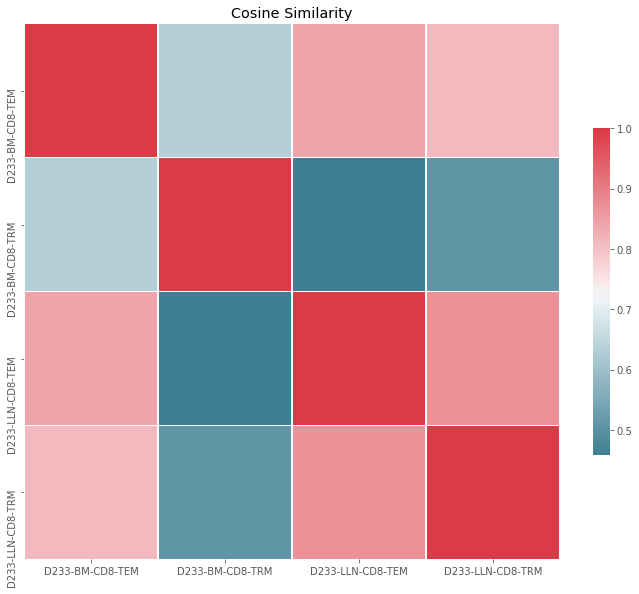

In [7]:
data = cosine_similarity(aggregate(df[df.subject == 'D233'], 'replicates'))

fig, ax = plt.subplots(figsize=(12, 12))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax = sns.heatmap(data=data, cmap=cmap, square=True, linewidths=.5,
                 cbar_kws={"shrink": .5}, ax=ax)

ax.set_title('Cosine Similarity')
plt.savefig('D233_replicates.pdf', bbox_inches='tight')